## Project 1
#### Eva Fong (xsg5by), Angelika Baloy (ybm4rn), Olivia Pang (pme3nf), Shreya Shanmugan (ney3yp), Shmera Shanmugan (pjt7xx)

### Part 1:

In [1]:
import pandas as pd
mdf = pd.read_csv('./data/linked_mortality_file_1999_2000.csv') # Load mortality file
print( mdf.head() )
gdf = pd.read_sas("./data/DEMO.xpt", format="xport") # Load demographics file
print( gdf.head() )
df = gdf.merge(mdf, on="SEQN", how="inner") # Merge mortality and demographics on SEQN variable

   SEQN  ELIGSTAT  MORTSTAT  UCOD_LEADING  DIABETES  HYPERTEN  PERMTH_INT  \
0     1         2       NaN           NaN       NaN       NaN         NaN   
1     2         1       1.0           6.0       0.0       0.0       177.0   
2     3         2       NaN           NaN       NaN       NaN         NaN   
3     4         2       NaN           NaN       NaN       NaN         NaN   
4     5         1       0.0           NaN       NaN       NaN       244.0   

   PERMTH_EXM  
0         NaN  
1       177.0  
2         NaN  
3         NaN  
4       244.0  
   SEQN  SDDSRVYR  RIDSTATR  RIDEXMON  RIAGENDR  RIDAGEYR  RIDAGEMN  RIDAGEEX  \
0   1.0       1.0       2.0       2.0       2.0       2.0      29.0      31.0   
1   2.0       1.0       2.0       2.0       1.0      77.0     926.0     926.0   
2   3.0       1.0       2.0       1.0       2.0      10.0     125.0     126.0   
3   4.0       1.0       2.0       2.0       1.0       1.0      22.0      23.0   
4   5.0       1.0       2.0       2.

#### Documentation for `ELIGSTAT`, `MORTSTAT`, `PERMTH_INT` and `RIDAGEEX`
- `ELIGSTAT`: The eligiblity status of an observation for mortality follow-up. Has three possible values of 1 for "Eligible", 2 for "Under age 18, not available for public release", and 3 for "Ineligible".

- `MORTSTAT`: The final mortality status of an observation. Has three possible values of 0 for "Assumed alive", 1 for "Assumed dead", and . for "Assumed alive, under 18, ineligible for mortality follow-up, or MCOD not available".

- `PERMTH_INT`: The number of months of follow-up from NHANES interview date. Possible integer values from 43 to 45. 

- `RIDAGEEX`: Age in months at date of examination for individuals under 85 years of age at screening.

In [2]:
body = pd.read_sas("./data/BMX.xpt", format="xport")
occupation = pd.read_sas("./data/OCQ.xpt", format="xport")
blood_pressure = pd.read_sas("./data/BPX.xpt", format="xport")
heart = pd.read_sas("./data/CDQ.xpt", format="xport")


#### Rationale for data selections

From the 2000-1999 NHANES data page, we are going to be using data on age, sex, education, income (DEMO), BMI (BMX), occupation (OCQ), blood pressure (BPQ), and heart condition (CDQ).

We chose these data because we are interested to see the influence of social-economic status on someone's mortality in addition to their health metrics. Age is, of course, is included as a part of our variable set as it is proven to be highly correlated to morality by research and by the exercises we did in class. Sex is also included to account for possible biological differences that might aid or hinder someone's life expectancy. 

Education, income, and occupation serve as the indicators for socioeconomic influences. The three together typically captures someone's access to human capital and resources available to them.

Finally, BMI, blood pressure, and heart conditions will help us identify the correlation between possible physiological risk factors and morality. 

In [3]:
df = df.merge(body, on="SEQN", how="left")
df = df.merge(occupation, on="SEQN", how="left")
df = df.merge(blood_pressure, on="SEQN", how="left")
df = df.merge(heart, on="SEQN", how="left")

In [4]:
missing = df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

BMAUPREL    9965
BMAUPLEL    9965
BMIHEAD     9964
BMALLKNE    9964
DMARACE     9963
            ... 
RIDAGEMN     173
DMDHRAGE      12
DMDHRGND      12
DMDBORN       11
DMDCITZN       3
Length: 141, dtype: int64

In the merged dataset, there are a total of 147 columns that have missing values, but that is expected given the sheer size of the dataset. 

To make documentation easier, we will only consider the missing values of the specific variables that we want to use.

In [5]:
var_set = [
    "ELIGSTAT", "MORTSTAT", "PERMTH_INT", #eligiblity, mortality status, months since follow-up
    "RIDAGEEX", #age
    "RIAGENDR", #sex
    "DMDEDUC2", #highest grade or level completed
    "INDFMPIR", #ratio of family income to poverty
    "BMXBMI", #body mass index
    "BPXSY1", #blood pressure, specifically pressure in artieries when heart beats
    "OCQ150", #type of work done last week
]

df_altered = df[var_set]
df_altered = df_altered[df_altered["ELIGSTAT"] == 1] #we will only be analyzing the participants that are eligible
missing_altered = df_altered.isnull().sum()
missing_altered[missing_altered > 0].sort_values(ascending=False)

#df_altered['RIDAGEEX'].describe()

BPXSY1      1107
INDFMPIR     841
RIDAGEEX     605
DMDEDUC2     570
BMXBMI       545
OCQ150         2
dtype: int64

#### Missing values

`BPXSY1` (blood pressure): this variable has the most missing values, likely to due participants who might've been unwilling to partake in a clinical examination

`INDFMPIR` (family income to poverty ratio): this missing values may be due to the people who provide their income to the survey

`RIDGEEX` (age): this is rather unusual, maybe a human or technical error, but should remove the observations with missing age

`BMXBMI` (BMI): again, could be missing due to participants not willing to undergo clinical examination


`OCQ150` (type of work done last week): only two missing, which means those two may just be non-responses

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# convert to df and removed observations with missing age
df_altered = pd.DataFrame(df_altered.dropna(subset=['RIDAGEEX']))

We are working with a total of 7 variables to predict mortality (MORTSTAT) and life expectancy (PERMTH_INT). First, I'd like to explore these two variables.

In [8]:
# MORTSTAT
df_altered['MORTSTAT'].value_counts()
# After wrangling, we are left with 3770 "Assumed alive" (0) and 1675 "Assumed dead" (1)
# This will function as a categorical variable in subsequent analyses.

MORTSTAT
0.0    3508
1.0    1332
Name: count, dtype: int64

In [9]:
# PERMTH_INT
df_altered['PERMTH_INT'].describe() # descriptive statistics for life expectancy
# The mean is lower than the median, suggesting a negative skew
# We can expect values ranging from 0 to 250, which I'm assuming is a cutoff

count    4840.000000
mean      208.880165
std        60.687650
min         1.000000
25%       221.000000
50%       236.000000
75%       243.000000
max       250.000000
Name: PERMTH_INT, dtype: float64

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='PERMTH_INT', ylabel='Count'>

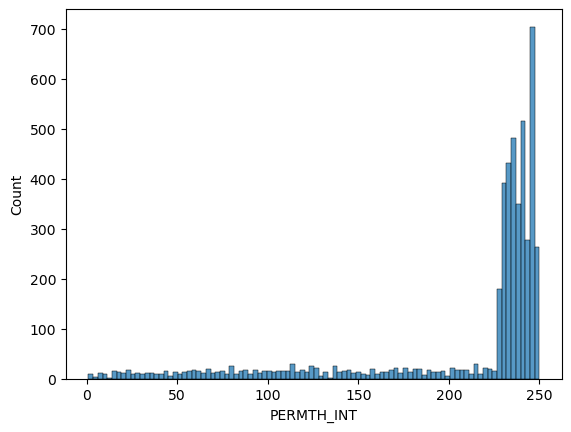

In [10]:
# PERMTH_INT Histogram
sns.histplot(df_altered['PERMTH_INT'])
# After creating a visualization, it is clear that most have 230+ months life expectancy,
# or survive until the end of the mortality period

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='PERMTH_INT', ylabel='Density'>

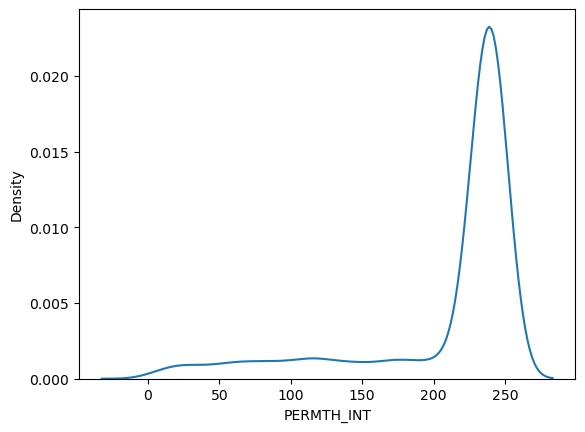

In [11]:
sns.kdeplot(data=df_altered['PERMTH_INT'])
# This reiterates what we've discovered with the previous histogram, but this kdeplot gives us
# a better idea of proportions. This distribution will be important to reference once we create
# our prediction models.

Next, on to our variables of interest: Age (RIDAGEEX), Gender (RIAGENDR), Education Level (DMDEDUC2), Family Poverty Income Ratio (INDFMPIR), Body Mass Index (BMXBMI), Systolic Blood Pressure (BPXSY1), and Occupation type (OCQ150).

In [12]:
# Age (in months)
df_altered['RIDAGEEX'].describe()


count    4840.000000
mean      553.576240
std       235.457568
min       216.000000
25%       343.750000
50%       530.000000
75%       758.000000
max      1019.000000
Name: RIDAGEEX, dtype: float64

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


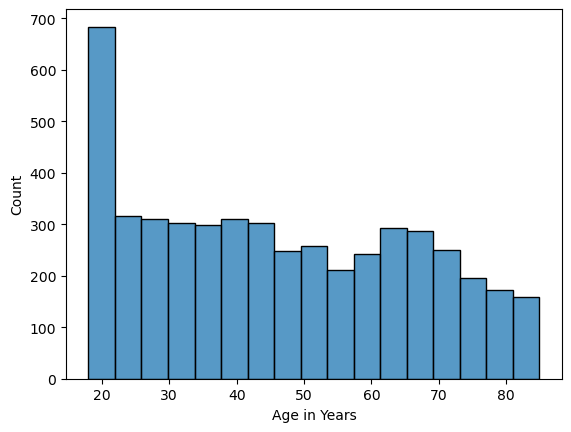

In [13]:
# Visualizing Age (in Years)
age_years = df_altered['RIDAGEEX']/12
sns.histplot(age_years)
plt.xlabel("Age in Years")
plt.show()
# Most of the people in the dataset were on the younger side.

In [14]:
# Gender
df_altered['RIAGENDR'].value_counts() # Close to even split between genders (1=Male/2=Female)

RIAGENDR
2.0    2568
1.0    2272
Name: count, dtype: int64

In [15]:
# Education Level
df_altered['DMDEDUC2'].value_counts() # Distribution of education level
# Most are either high school graduates or obtained some college or Associates

DMDEDUC2
3.0    981
4.0    964
2.0    859
1.0    794
5.0    699
9.0      9
7.0      3
Name: count, dtype: int64

In [16]:
# Family Poverty Income Ratio
df_altered['INDFMPIR'].describe() # range= 0 to 5

count    4.153000e+03
mean     2.440135e+00
std      1.607828e+00
min      5.397605e-79
25%      1.070000e+00
50%      2.040000e+00
75%      3.880000e+00
max      5.000000e+00
Name: INDFMPIR, dtype: float64

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


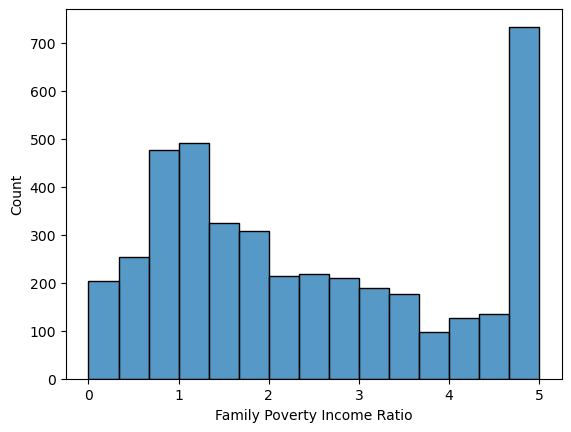

In [17]:
# Family PIR Histogram
sns.histplot(df_altered['INDFMPIR'])
plt.xlabel("Family Poverty Income Ratio")
plt.show()
# Appears to be bimodal, with two distinct peaks around 1 and 5 (ceiling effect, like PERMTH_INT)
# This reveals that most families' income was similar to the poverty line or far exceeded it.


In [18]:
# BMXBMI
df_altered['BMXBMI'].describe() # 12.04 to 66.44

count    4781.000000
mean       28.105451
std         6.294096
min        12.040000
25%        23.700000
50%        27.050000
75%        31.450000
max        66.440000
Name: BMXBMI, dtype: float64

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


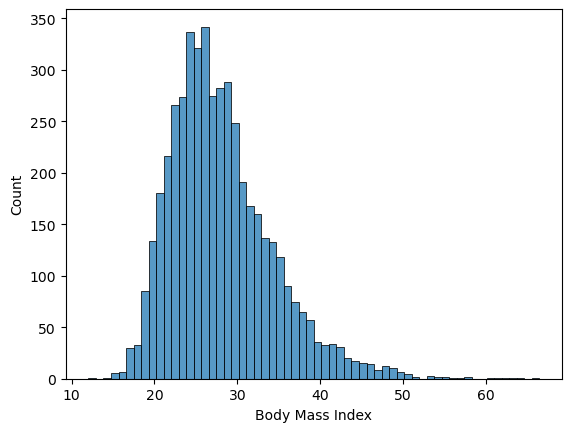

In [19]:
# BMI Visualization
sns.histplot(df_altered['BMXBMI'])
plt.xlabel("Body Mass Index")
plt.show()

Because of this spread and positive skew, I create a boxplot to see if there are any upper outliers.

<Axes: xlabel='BMXBMI'>

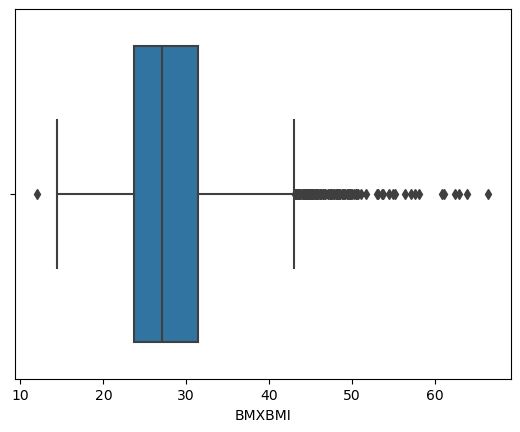

In [20]:
sns.boxplot(x=df_altered['BMXBMI'])
# There are many upper outliers as well as one lower outlier

BMI is tricky because of how BMI categories are set up. Anything outside of 18.5-24.9 is considered potentially problematic to one's health (though BMI as a measure of the quality of one's health is debatable). I create another histogram to help us visualize the BMI categories.

In [21]:
BMI_cat = df_altered['BMXBMI']

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


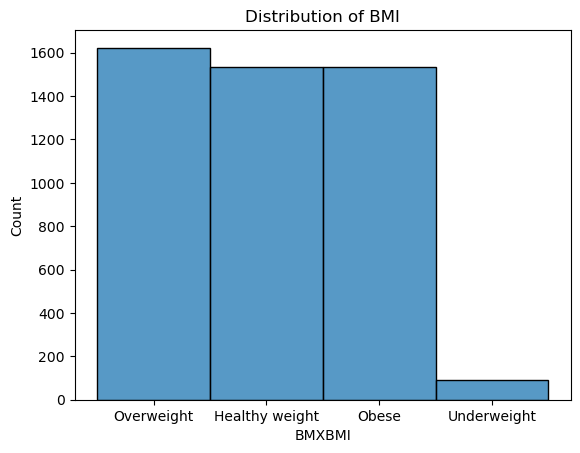

In [22]:
# Function to categorize BMI values
def bmi_category(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 24.9:
        return 'Healthy weight'
    elif 24.9 <= bmi < 29.9:
        return 'Overweight'
    elif bmi >= 29.9:
        return 'Obese'
    else:
        return np.nan # For missing BMI values


sns.histplot(BMI_cat.apply(bmi_category))
plt.title("Distribution of BMI")
plt.show()

# We can see here that most of the sample is overweight or obese. A decent portion are
# within the healthy weight range. Few are underweight.

In [23]:
# Systolic Blood Pressure
df_altered['BPXSY1'].describe() # ranges from 76 to 242
# 242 seems like a dangerously high number

count    4227.000000
mean      126.308020
std        22.020142
min        76.000000
25%       110.000000
50%       122.000000
75%       138.000000
max       242.000000
Name: BPXSY1, dtype: float64

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='BPXSY1', ylabel='Count'>

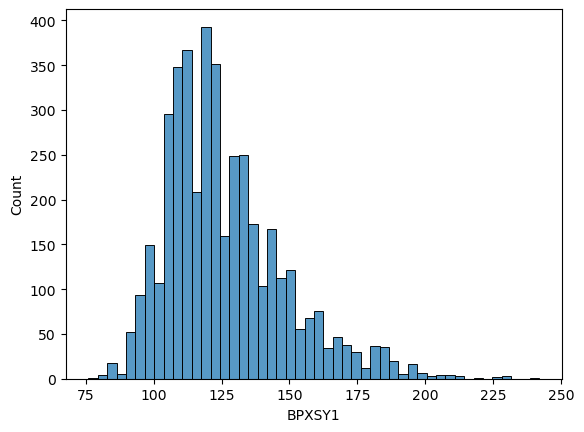

In [24]:
# Systolic Blood Pressure Histogram
sns.histplot(df_altered['BPXSY1'])

<Axes: xlabel='BMXBMI'>

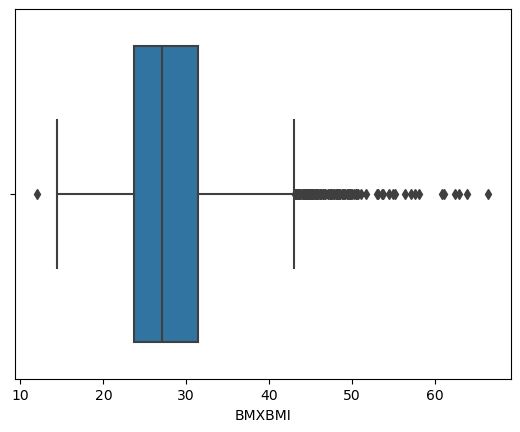

In [26]:
# Looking for outliers
sns.boxplot(x=df_altered['BMXBMI'])
# There are several upper outliers

In [ ]:
# Occupation - type of work done last week
df_altered['OCQ150'].value_counts()
# This also functions like a categorical variable.
# Most responded 1, which means that they were working at a job or business within the
# last week. Many responded 4 as well, which means they have a job but were not present at
# work within the last week.

,count
OCQ150,
1.0,2804
4.0,2412
2.0,126
3.0,95
7.0,5
9.0,1


We can also expect to see relationships between our variables of interest.

<Axes: xlabel='RIDAGEEX', ylabel='Density'>

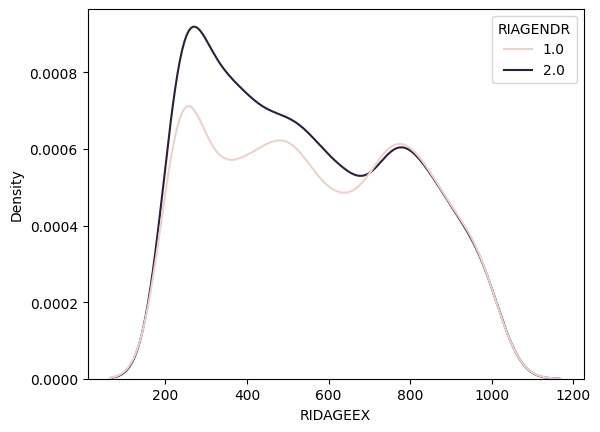

In [ ]:
# Age and Gender
sns.kdeplot(data=df_altered, x='RIDAGEEX', hue='RIAGENDR')
# Age distributions are somewhat similar between genders

In [ ]:
# Gender and Occupation
pd.crosstab(df_altered['RIAGENDR'], df_altered['OCQ150'])
# Gender does not seem to impact the type of work done

OCQ150,1.0,2.0,3.0,4.0,7.0,9.0
RIAGENDR,,,,,,
1.0,1501,61,43,938,3,1
2.0,1303,65,52,1474,2,0


In [ ]:
# Gender and Mortality
pd.crosstab(df_altered['RIAGENDR'], df_altered['MORTSTAT']) # 0=assumed alive // 2=Female
# Similar to the assumed alive/dead ratio in MORTSTAT alone, suggesting that there are minimal
# gender differences in mortality

MORTSTAT,0.0,1.0
RIAGENDR,,
1.0,1665,883
2.0,2105,792


In [ ]:
# BMI categories and Mortality
pd.crosstab(BMI_cat.apply(bmi_category), df_altered['MORTSTAT'])
# BMI category seems to have little impact on mortality

MORTSTAT,0.0,1.0
BMXBMI,,
Healthy weight,1181,406
Obese,1078,474
Overweight,1168,503
Underweight,66,24


<Axes: xlabel='RIDAGEEX', ylabel='Density'>

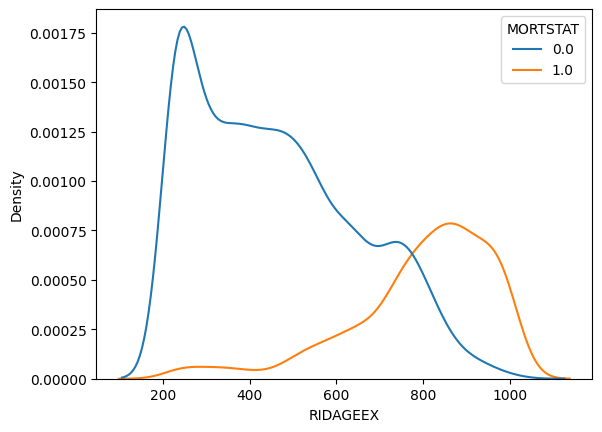

In [ ]:
# Mortality and Age
sns.kdeplot(data=df_altered, x='RIDAGEEX', hue='MORTSTAT')
# Those who are assumed alive include most of the age range, but fall off at the upper bound.
# Those who are assumed dead are mostly those who occupy the upper half of the age range.
# Age is potentially a good predictor of mortality.

<Axes: xlabel='RIDAGEEX', ylabel='PERMTH_INT'>

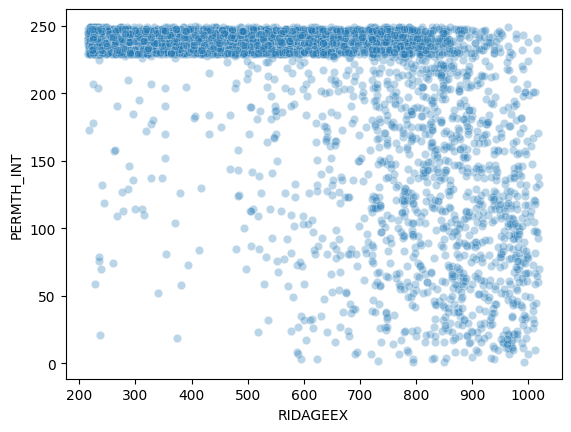

In [ ]:
# Age and life expectancy
sns.scatterplot(data=df_altered, x='RIDAGEEX', y='PERMTH_INT', alpha=.3)
# No obvious relationship here; large cluster at PERMTH_INT upper bound


<Axes: xlabel='INDFMPIR', ylabel='Density'>

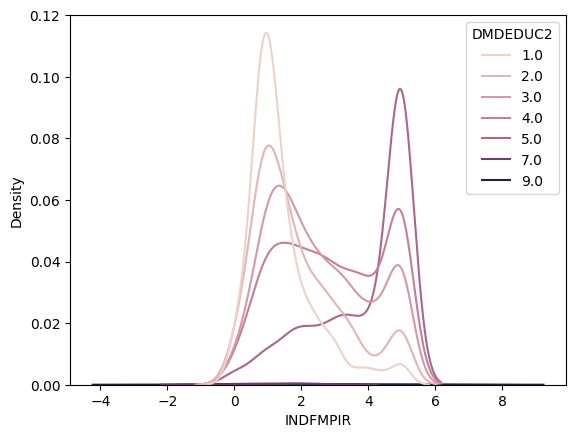

In [ ]:
# Education level and Family PIR
sns.kdeplot(data=df_altered, x='INDFMPIR', hue='DMDEDUC2')
# We can see here that, once grouped by education level, the Family PIR follows a different
# distribution. More education is associated with higher Family PIR, evidenced by the location
# of peaks. Distributions still bimodal, except for ED level 5.

<Axes: xlabel='INDFMPIR', ylabel='Density'>

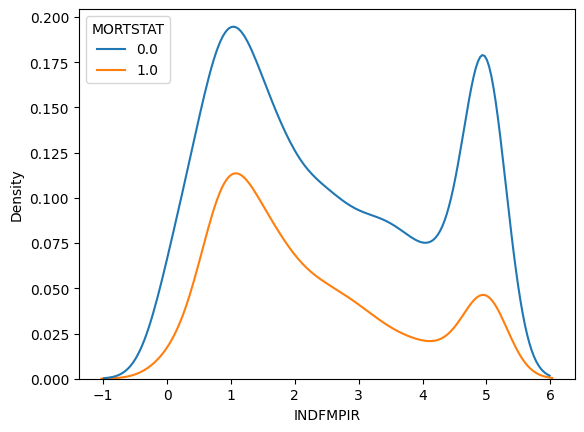

In [ ]:
# Family PIR and Mortality
sns.kdeplot(data=df_altered, x='INDFMPIR', hue='MORTSTAT')
# Those assumed alive or dead follow similarly shaped distributions across Family PIR,
# suggesting that Family PIR is not a good standalone predictor of mortality.

            INDFMPIR  PERMTH_INT
INDFMPIR    1.000000    0.109559
PERMTH_INT  0.109559    1.000000


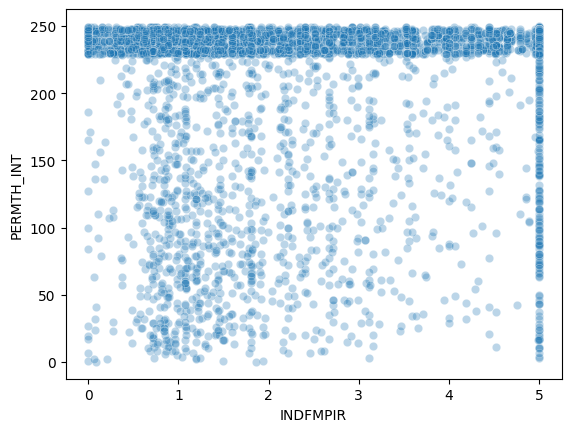

In [ ]:
# Family PIR and Life expectancy
sns.scatterplot(data=df_altered, x='INDFMPIR', y='PERMTH_INT', alpha=.3)
# Life expectancy does not appear to have a strong relationship with Family PIR, suggesting that
# income level is not predictive of life expectancy
print(df_altered.loc[:, ['INDFMPIR', 'PERMTH_INT']].corr())

          BMXBMI    BPXSY1
BMXBMI  1.000000  0.157041
BPXSY1  0.157041  1.000000


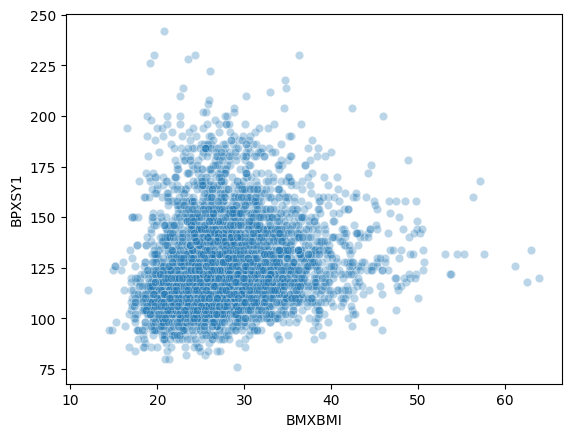

In [ ]:
# Blood Pressure and BMI
sns.scatterplot(data=df_altered, x='BMXBMI', y='BPXSY1', alpha=.3)
# Considering that BP and BMI both follow positively skewed distributions, most of the points here
# are clustered and then flare out.
print(df_altered.loc[:, ['BMXBMI', 'BPXSY1']].corr())
# The correlation between the two variables verifies that this is a weak positive linear relationship

              BMXBMI  PERMTH_INT
BMXBMI      1.000000    0.022518
PERMTH_INT  0.022518    1.000000


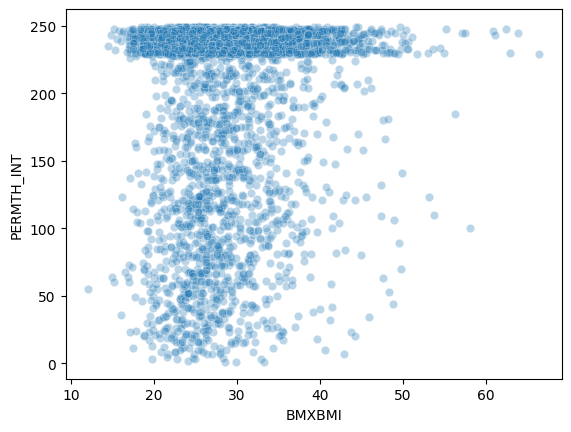

In [ ]:
# Life expectancy and BMI
sns.scatterplot(data=df_altered, x='BMXBMI', y='PERMTH_INT', alpha=.3)
# Again, the points are clustered at the life expectancy upper bound.
print(df_altered.loc[:, ['BMXBMI', 'PERMTH_INT']].corr())
# There is no correlation between the two variables

<Axes: xlabel='PERMTH_INT', ylabel='Density'>

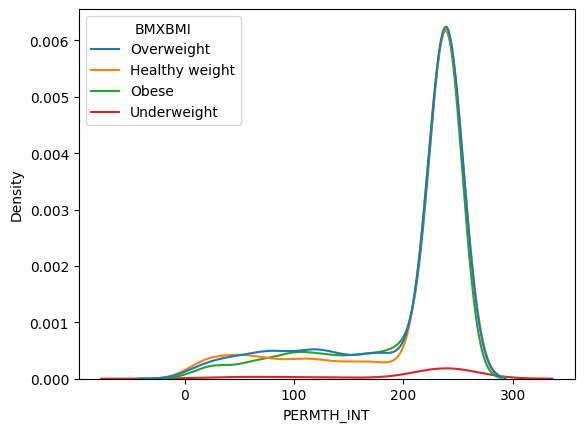

In [ ]:
# Life expectancy and BMI (cont)
sns.kdeplot(data=df_altered, x='PERMTH_INT', hue=BMI_cat.apply(bmi_category))


              BPXSY1  PERMTH_INT
BPXSY1      1.000000   -0.402654
PERMTH_INT -0.402654    1.000000


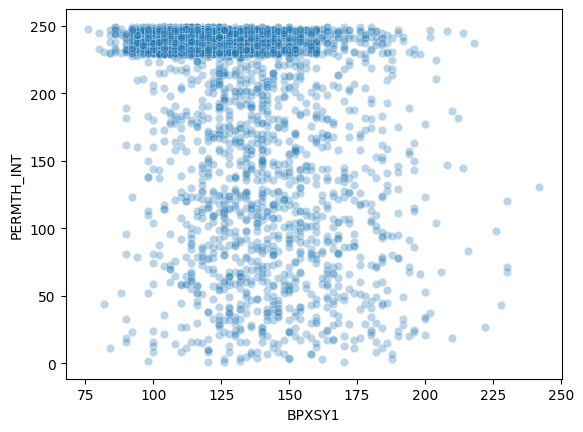

In [ ]:
# Life expectancy and blood pressure
sns.scatterplot(data=df_altered, x='BPXSY1', y='PERMTH_INT', alpha=.3)
print(df_altered.loc[:, ['BPXSY1', 'PERMTH_INT']].corr())
# There is a weak, negative correlation between the variables.

### Part 2: